In [1]:
# #installing keras-tuner
# !pip install keras-tuner

In [2]:
#importing necessary liabraries
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np


In [3]:
#loading dataset and spliting it in test and train dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [4]:
#check x_train shape
x_train.shape


(60000, 28, 28)

In [5]:
#setting the y_train data
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

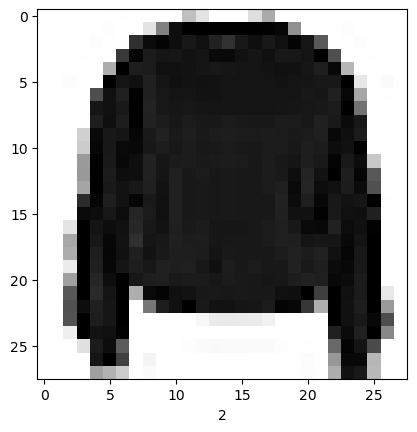

In [6]:
#checking a random element 7 and visualizing it
plt.imshow(x_train[7],cmap='binary')
plt.xlabel(y_train[7])
plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
training_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(training_images.reshape(-1, 28, 28, 1)))
training_images = tf.image.resize(training_images, [75, 75]) / 255.0
test_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_images.reshape(-1, 28, 28, 1)))
test_images = tf.image.resize(test_images, [75, 75]) / 255.0

# Load the InceptionV3 model, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(75, 75, 3)))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(training_images, training_labels, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)